# Notebook to visualize runs pulled from wandb
This notebook should be extended

## Setup

In [1]:
import wandb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
import os
from typing import List, Dict, Optional
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# Initialize wandb API
api = wandb.Api()

# Project configuration
PROJECT_NAME = os.getenv("WANDB_PROJECT", "eoss")
ENTITY = None  # Leave None for default entity

# Parallelism configuration
USE_PARALLEL_FETCH = True  # Set to False to disable parallel fetching
MAX_WORKERS = 8  # Number of parallel workers for fetching data

wandb: WARNING Unable to verify login in offline mode.


# Wandb Run Data Retrieval and Visualization

This notebook replaces the file-based approach with wandb API calls to retrieve and visualize training metrics.

In [3]:
import importlib
import sys
# Add the data_vis folder to the Python path
import os
current_path = os.getcwd()
# Find the eoss folder in the path
eoss_index = current_path.find('eoss')
if eoss_index != -1:
    eoss_path = current_path[:eoss_index + 4]  # Include 'eoss' in the path
    data_vis_path = os.path.join(eoss_path, 'data_vis')
    if data_vis_path not in sys.path:
        sys.path.insert(0, data_vis_path)

from vis_utils import Run, RunCollection

# # Force reload the vis_utils module

# # Remove module from cache if it exists
# if 'vis_utils' in sys.modules:
#     importlib.reload(sys.modules['vis_utils'])

# Import the classes

# print("vis_utils module reloaded successfully")
# print("Run and RunCollection classes imported")

wandb: WARNING Unable to verify login in offline mode.


# Load Data from Wandb



### Get the latest runs and info

# Two-Step Workflow: Browse Runs, Then Load Data

For better performance, first browse available runs by metadata only, then load full dataframes for selected runs.

In [4]:
# NEW APPROACH: Using Run class directly
print("Step 1: Getting latest runs metadata (fast)...")
n_latest = 10
filters = {
    # "config.dataset": "cifar10",
    # "config.model": "mlp", 
    # "state": "finished"
}

# Get runs as Run objects (metadata loaded, DataFrames not yet loaded)
available_runs = RunCollection.get_latest_runs(n_latest, filters)
print(f"Found {len(available_runs)} runs\n")

# Display available runs for selection
for i, run in enumerate(available_runs):
    print(f"{i+1}. {run.run_name} (ID: {run.run_id})")
    print(f"   Dataset: {run.metadata['dataset']}, Model: {run.metadata['model']}")
    print(f"   Batch: {run.batch_size}, LR: {run.lr}")
    print(f"   Created: {run.metadata['created_at']}")
    
    # Add other metadata if present
    extra_info = []
    if 'momentum' in run.config and run.config['momentum'] is not None:
        extra_info.append(f"Momentum: {run.config['momentum']}")
    if run.config.get('sde', False):
        extra_info.append("SDE: True")
    if run.config.get('gd_noise', False):
        extra_info.append("GD Noise: On")
    if extra_info:
        print(f"   {', '.join(extra_info)}")
    print()

Step 1: Getting latest runs metadata (fast)...
Found 10 runs

1. cifar10_cnn_b8_lr0.02-trace (ID: zkbr2vwi)
   Dataset: cifar10, Model: cnn
   Batch: 8, LR: 0.02
   Created: 2025-09-25T09:51:27Z

2. cifar10_cnn_b16_lr0.02-trace (ID: i16ofrlw)
   Dataset: cifar10, Model: cnn
   Batch: 16, LR: 0.02
   Created: 2025-09-25T09:51:19Z

3. cifar10_cnn_b16_lr0.02-trace (ID: wbbq7rzk)
   Dataset: cifar10, Model: cnn
   Batch: 16, LR: 0.02
   Created: 2025-09-25T09:23:54Z

4. cifar10_cnn_b8_lr0.02-trace (ID: 1k2z52ns)
   Dataset: cifar10, Model: cnn
   Batch: 8, LR: 0.02
   Created: 2025-09-25T09:23:46Z

5. cifar10_mlp_b8_lr0.02-trace (ID: sciyonq9)
   Dataset: cifar10, Model: mlp
   Batch: 8, LR: 0.02
   Created: 2025-09-25T08:27:50Z

6. cifar10_mlp_b8_lr0.02-trace (ID: dtb5wf2n)
   Dataset: cifar10, Model: mlp
   Batch: 8, LR: 0.02
   Created: 2025-09-25T08:27:40Z

7. cifar10_mlp_b8_lr0.01-trace (ID: uxxeu5yx)
   Dataset: cifar10, Model: mlp
   Batch: 8, LR: 0.01
   Created: 2025-09-25T08:21:4

### Option 1: List of run ids

In [5]:
run_ids = [
    'i16ofrlw',
    'zkbr2vwi'
    # Add more run IDs as needed
]

# Create a collection and load DataFrames
print("Loading runs using RunCollection...")
collection = RunCollection.from_run_ids(run_ids)
print(f"Loaded {len(collection)} runs")

Loading runs using RunCollection...
Loaded 2 runs


### Option 2: Using a tag

In [18]:
collection = RunCollection.from_tag('ps_phase_lr_sweep_2')

Found 20 runs with tag 'ps_phase_lr_sweep_2'


## Load the data (takes some time)

In [6]:
# Display summary of loaded runs
collection.print_summary()

RunCollection with 2 runs:
--------------------------------------------------------------------------------
1. cifar10_cnn_b16_lr0.02-trace (ID: i16ofrlw)
   Dataset: cifar10, Model: cnn
   Batch: 16, LR: 0.02
   Created: 2025-09-25T09:51:19Z

2. cifar10_cnn_b8_lr0.02-trace (ID: zkbr2vwi)
   Dataset: cifar10, Model: cnn
   Batch: 8, LR: 0.02
   Created: 2025-09-25T09:51:27Z



In [7]:
# loading the dataframes
# THIS ONE TAKES TIME!
collection.load_all_dataframes()

Loading dataframes for 2 runs using 8 workers...


In [8]:
collection.sort_by_batch_size()

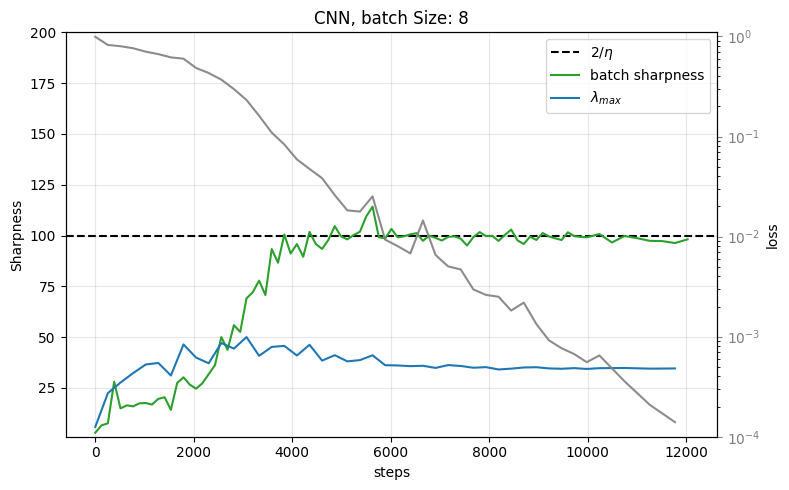

Run 1/2: cifar10_cnn_b8_lr0.02-trace
Run ID: zkbr2vwi
Dataset: cifar10, Model: cnn
Data points: 12289
--------------------------------------------------


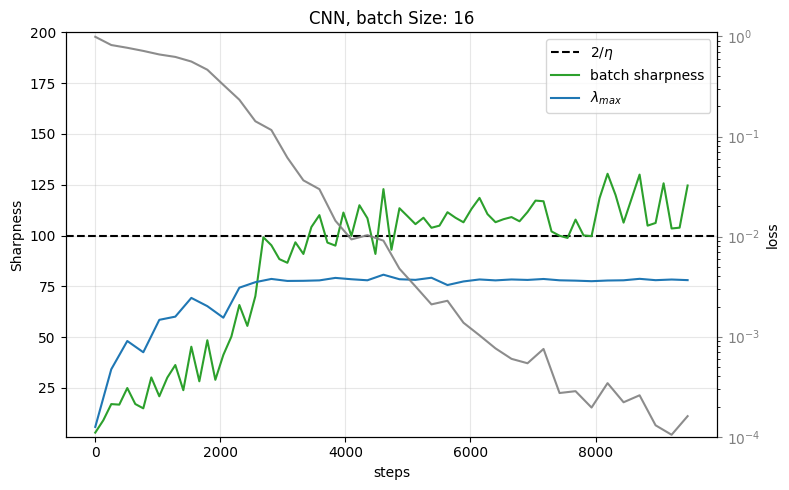

Run 2/2: cifar10_cnn_b16_lr0.02-trace
Run ID: i16ofrlw
Dataset: cifar10, Model: cnn
Data points: 9601
--------------------------------------------------


In [17]:
# NEW PLOTTING APPROACH: Using Run objects directly

from pathlib import Path


def plot_run(run: Run, ax=None):
    """Plot a single run's sharpness metrics."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))

    lr = run.lr
    batch_size = run.batch_size
    run_name = run.run_name
    df = run.df

    if pd.isna(lr) or pd.isna(batch_size):
        print(f"Skipping run {run_name} due to missing lr or batch_size")
        return ax

    handles = []
    labels = []

    reference = ax.axhline(y=2 / lr, color='black', linestyle='--', label=r'2/$\eta$')
    handles.append(reference)
    labels.append(reference.get_label())
    ax.set_ylim(1, 2 / lr * 2)

    if run.has_metric('batch_sharpn'):
        bs_data = run.get_metric_data('batch_sharpn')
        ax.plot(bs_data['_step'], bs_data['batch_sharpn'], color='#2ca02c', linewidth=1.5, label='batch sharpness')

    if run.has_metric('lambda_max'):
        lambda_data = run.get_metric_data('lambda_max')
        lambda_line = ax.plot(lambda_data['_step'], lambda_data['lambda_max'], color='#1f77b4', linewidth=1.5, label=r'$\lambda_{max}$')[0]
        handles.append(lambda_line)
        labels.append(lambda_line.get_label())

    ax.set_ylabel('Sharpness')

    loss_metric = None
    for candidate in ['full_loss', 'loss']:
        if run.has_metric(candidate):
            loss_metric = candidate
            break

    if loss_metric:
        ax3 = ax.twinx()
        # ax3.spines['right'].set_position(('outward', 60))
        loss_data = run.get_metric_data(loss_metric)
        if loss_data.empty:
            if 'step' in df.columns:
                loss_steps = df['step']
            else:
                loss_steps = df['_step']
            loss_values = df[loss_metric].interpolate()
        else:
            loss_steps = loss_data['_step']
            loss_values = loss_data[loss_metric].interpolate()
        loss_line = ax3.plot(loss_steps, loss_values, color='gray', linewidth=1.5, alpha=0.9, label='full loss')[0]
        ax3.set_ylabel('loss')
        ax3.set_yscale('log')
        ax3.set_ylim(1e-4, 1.1)
        ax3.tick_params(axis='y', colors='gray')
        handles.append(loss_line)
        labels.append(loss_line.get_label())

    ax.set_title(f'CNN, batch Size: {batch_size}')
    ax.set_xlabel('steps')
    ax.grid(True, alpha=0.3)


    ax.legend(loc='upper right')

    return ax


# Plot all runs in the collection
for i, run in enumerate(collection):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_run(run, ax)
    plt.tight_layout()

    filename = f'trace_cnn_bs_{run.batch_size}.png'

    dir_path = Path(f'../img/trace/')
    dir_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(dir_path / filename, dpi=300, bbox_inches='tight')
    plt.show()

    


    print(f"Run {i+1}/{len(collection)}: {run.run_name}")
    print(f"Run ID: {run.run_id}")
    print(f"Dataset: {run.metadata['dataset']}, Model: {run.metadata['model']}")
    print(f"Data points: {len(run.df)}")
    print("-" * 50)
